In [723]:
FROM_DATASET = True
N_SAMPLES = 10000
PARTITION = int(N_SAMPLES*0.1)
ITERS = 30
EPSILON = 1e-5

In [724]:
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import time
import math

## Dataset

In [725]:
#diabetes, Surgical-deepnet
DATASET = 'Surgical-deepnet' 

In [726]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    if DATASET == "diabetes":
        data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
        np.random.shuffle(data)
        X = data[:, :-1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)

        print("Principal Component Analysis")
        print("Shape 1: " +  str(X.shape))
        X = PCA(n_components=2).fit_transform(X)
        print("Shape 2: " +  str(X.shape))

    elif DATASET == "Surgical-deepnet":
        data = np.genfromtxt('Surgical-deepnet.csv', delimiter=',', skip_header=1)
        np.random.shuffle(data)
        X = data[:, : -1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)

        print("Principal Component Analysis")
        print("Shape 1: " +  str(X.shape))
        X = PCA(n_components=5).fit_transform(X)
        print("Shape 2: " +  str(X.shape))


Principal Component Analysis
Shape 1: (14635, 24)
Shape 2: (14635, 5)


In [727]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

X.shape

Dataset Lenght
Tot: 14635, lab: 1000, unlab: 13635


(14635, 5)

In [728]:
# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

# Label initialization
labeled_y = np.array(y[:PARTITION])
target_y = np.array(y[PARTITION:])
initial_y = np.random.choice([-1,1], size = (len(unlabeled_X,)))

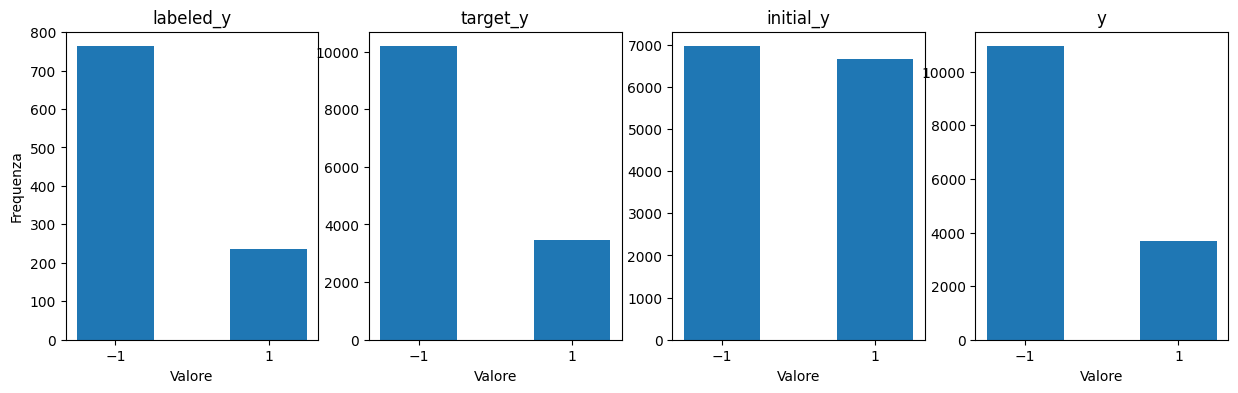

In [729]:
# Distribution
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

bin_edges = [-1.5, -0.5, 0.5, 1.5]

axs[0].hist(labeled_y, bins=bin_edges)
axs[1].hist(target_y, bins=bin_edges)
axs[2].hist(initial_y, bins=bin_edges)
axs[3].hist(y, bins=bin_edges)

for ax in axs:
    ax.set_xticks([-1, 1])
    ax.set_xlabel('Valore')

axs[0].set_ylabel('Frequenza')

axs[0].set_title('labeled_y')
axs[1].set_title('target_y')
axs[2].set_title('initial_y')
axs[3].set_title('y')

plt.show()

### Labeled-Unlabeled Euclidean distances

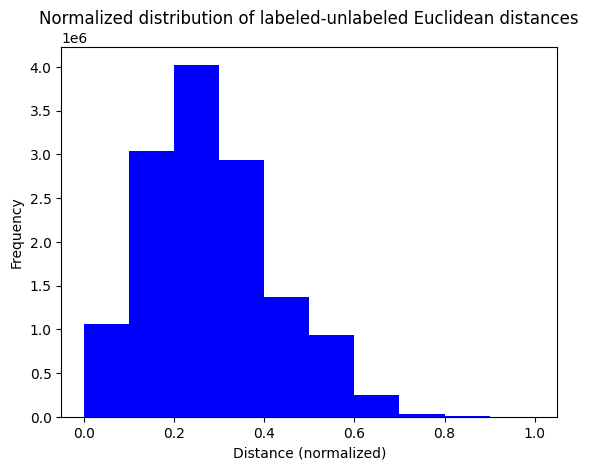

In [730]:

# Calculate distances
labeled_distances = cdist(labeled_X, unlabeled_X) 

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of labeled-unlabeled Euclidean distances')

# Show the plot
plt.show()

### Unlabeled-Unlabeled Euclidean distances

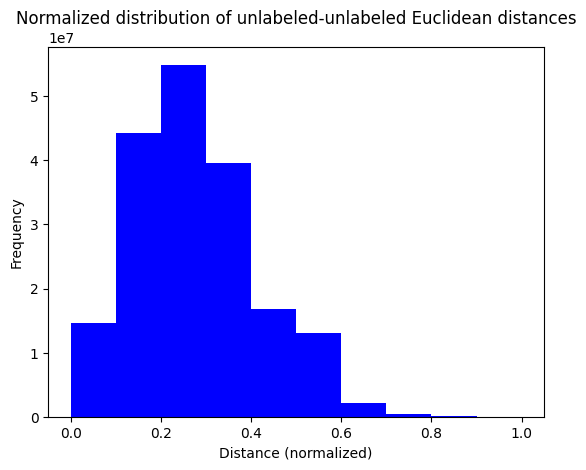

In [731]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of unlabeled-unlabeled Euclidean distances')

# Show the plot
plt.show()


In [732]:
if not FROM_DATASET:
    plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
    plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=labeled_y)
    plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
weight(a,b) = \frac{1}{1 + ||a-b||}
$$

In [733]:
def weight(dist): 
    return 1 / (1 + dist)

In [734]:
%%time
print("Computing weights")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_distances)
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_distances)
print('Done')

Computing weights
Done
CPU times: user 57 s, sys: 27.3 s, total: 1min 24s
Wall time: 2min 24s


The following is the implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$

In [735]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    labeled_unlabeled_loss = np.sum(np.power(Y - Y_bar.T, 2) * labeled_unlabeled_weights.T)
    unlabeled_unlabeled_loss = np.sum(np.power(Y - Y.T, 2) * unlabeled_unlabeled_weights.T)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy:

In [736]:
def accuracy(current):
    return np.sum(np.equal((current/2 + .5).round() * 2 - 1, target_y)) / len(target_y)

### Hessian and Lipschitz constant

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.

In [737]:
def hessian_matrix(unlabeled_unlabeled_w, labeled_unlabeled_w):
    matrix = np.copy(-unlabeled_unlabeled_w)
    
    for i in range(len(target_y)):
        matrix[i][i] = 2 * np.sum(labeled_unlabeled_w[:,i]) + np.sum(unlabeled_unlabeled_w[:,i]) - unlabeled_unlabeled_w[i][i]
    return matrix

def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]


In [738]:
%%time
print("Hessian matrix")
hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)

print("Calculating sigma (strongly convex)")
sigma = is_strongly_convex(hessian)
is_sc = sigma > 0

if is_sc: print(f"Sigma: {sigma}, strongly convex")
else: print(f"Sigma: {sigma}, not strongly convex")

L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")

print("Lipschitz constant for single variable")
Li = np.repeat(L, len(hessian))

Hessian matrix
Calculating sigma (strongly convex)
Sigma: 128.92883848003504, strongly convex
Lipschitz constant: 3481.7714089280857
Lipschitz constant for single variable
CPU times: user 27min 21s, sys: 7min 48s, total: 35min 9s
Wall time: 8min 20s


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

Following are some constant that are going to be used in the gradient, we compute outside the gradient function avoiding usless computation

In [739]:
print("Computing constants of the gradient")

label_unlabel_tot = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
unlabel_unlabel_tot = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))

first_constant = (2 * label_unlabel_tot) + unlabel_unlabel_tot
second_constant = 2 * np.multiply(
    labeled_y.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))

print("Done")

Computing constants of the gradient
Done


In [740]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_constant = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (first_constant * unlabeled - second_constant - third_constant).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [741]:
y_unlabeled_gd = np.copy(initial_y)

In [742]:
%%time
ticks_gd = [0]
acc_gd = [accuracy(y_unlabeled_gd)]
loss_gd = [loss(labeled_y, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0:
        print(f"{int(i/ITERS*100):02}%", end="")
    start = time.process_time()
    
    grad = gradient(y_unlabeled_gd)
    if EPSILON >= np.linalg.norm(grad): break # Condition
    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad # Gradient Step
    
    acc_gd.append(accuracy(y_unlabeled_gd))
    loss_gd.append(loss(labeled_y, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0:
        print(f" - acc {(acc_gd[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd):05.2f}")
        
print(f"""
Final accuracy: {round(acc_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(labeled_y, y_unlabeled_gd)}
""")

00% - acc 59.98% - loss 5504499.18
10% - acc 59.98% - loss 1972035.77
20% - acc 60.81% - loss 1065019.04
30% - acc 72.26% - loss 799458.44
40% - acc 74.66% - loss 701554.80
50% - acc 74.67% - loss 652832.67
60% - acc 74.67% - loss 621731.82
70% - acc 74.68% - loss 598944.98
80% - acc 74.68% - loss 581210.70
90% - acc 74.68% - loss 567064.20

Final accuracy: 74.68%
Norm gradient: 3022.1806552381595
Loss: 559196.0446706392

CPU times: user 6min 13s, sys: 2min 28s, total: 8min 41s
Wall time: 10min 8s


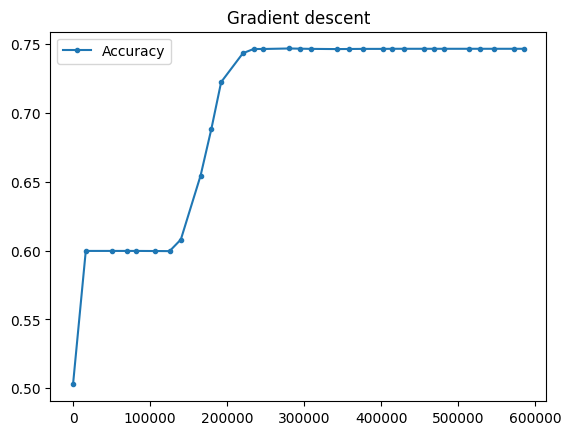

In [743]:
plt.figure(dpi=100)
plt.title("Gradient descent")
plt.plot(ticks_gd, acc_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = \frac{2}{L+sigma}
$$
in case the problem is strongly convex

In [744]:
y_unlabeled_gd_improved = np.copy(initial_y)

In [745]:
%%time
ticks_gd_improved = [0]
acc_gd_improved = [accuracy(y_unlabeled_gd_improved)]
loss_gd_improved = [loss(labeled_y, y_unlabeled_gd_improved)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}%", end="")
    start = time.process_time()
    
    grad = gradient(y_unlabeled_gd_improved)
    if EPSILON >= np.linalg.norm(grad): break # Condition
    
    # Gradient Step
    if is_sc: y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 / (L + sigma)) * grad # strongly convex
    else: y_unlabeled_gd_improved = y_unlabeled_gd_improved - (1 / L) * grad # not strongly convex

    acc_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    loss_gd_improved.append(loss(labeled_y, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0:
        print(f" - acc {(acc_gd_improved[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_improved):05.2f}")
        
print(f"""
Final accuracy: {round(acc_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(labeled_y, y_unlabeled_gd_improved)}
""")

00% - acc 49.89% - loss 11070929.70
10% - acc 57.07% - loss 5751495.00
20% - acc 74.68% - loss 3793745.38
30% - acc 74.67% - loss 2611692.32
40% - acc 74.68% - loss 1858037.25
50% - acc 74.68% - loss 1374605.30
60% - acc 74.68% - loss 1064146.66
70% - acc 74.68% - loss 864649.18
80% - acc 74.68% - loss 736375.49
90% - acc 74.68% - loss 653837.42

Final accuracy: 74.68%
Norm gradient: 19616.93125224641
Loss: 615876.4355877752

CPU times: user 6min 33s, sys: 3min 5s, total: 9min 38s
Wall time: 12min 35s


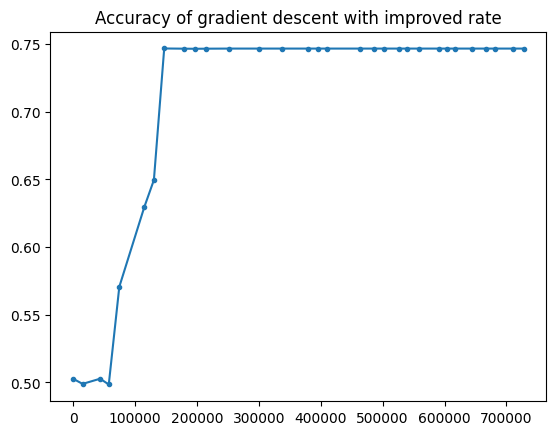

In [746]:
plt.figure(dpi=100)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, acc_gd_improved, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [747]:
def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, first_constant
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= first_constant[index] * step
    return step, new_grad

### Randomized

In Randomized BCGD method we randomly pick $i_k \in {1,...,b}$ and then we set:

$
x_{k+1} = x_k - \alpha_k \nabla_{i_k} f(x_k)
$

with $ \alpha_k = \frac{1}{L} $

In [748]:
y_unlabeled_bcgd_random = np.copy(initial_y).astype("float64")

In [749]:
%%time
ticks_bcgd_random= [0]
acc_bcgd_random = [accuracy(y_unlabeled_bcgd_random)]
loss_bcgm_random = [loss(labeled_y, y_unlabeled_bcgd_random)]

previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}%", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random): break # Condition

    if (i+1) % len(target_y) == 0:
        acc_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        loss_bcgm_random.append(loss(labeled_y, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - acc {(acc_bcgd_random[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(acc_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_random)}
""")

00% - acc 50.27% - loss 17103068.35
10% - acc 59.46% - loss 3769482.65
20% - acc 62.11% - loss 1625211.14
30% - acc 67.67% - loss 1028019.44
40% - acc 72.56% - loss 798553.88
50% - acc 74.29% - loss 700093.58
60% - acc 74.58% - loss 650005.82
70% - acc 74.64% - loss 618146.19
80% - acc 74.66% - loss 595300.24
90% - acc 74.67% - loss 578458.03

Final accuracy: 74.68%
Norm gradient: 3452.447295669434
Loss: 564834.0041144643

CPU times: user 6min 49s, sys: 2min 50s, total: 9min 39s
Wall time: 11min 10s


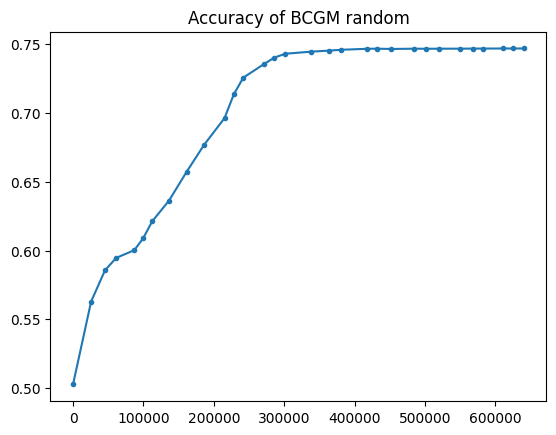

In [750]:
plt.figure(dpi=100)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, acc_bcgd_random, marker='.')

### Gauss-Southwell

In Gauss-Southwell BCGD method we pick block $i_k = Argmax|| \nabla_j f(x_k) ||$ with $j \in {1,...,b}$ and then we set:

$
x_{k+1} = x_k - \frac{1}{L} \nabla_{i_k} f(x_k)
$

In [751]:
y_unlabeled_bcgd_gs = np.copy(initial_y).astype("float64")

In [752]:
%%time
ticks_bcgd_gs = [0]
acc_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
loss_bcgm_gs = [loss(labeled_y, y_unlabeled_bcgd_gs)]

max_iterations = ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs): break # Condition

    if (i+1) % len(target_y) == 0:
        acc_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        loss_bcgm_gs.append(loss(labeled_y, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(acc_bcgd_gs[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_gs):05.2f}")

print(f"""
Final accuracy: {round(acc_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 409050 - final accuracy 50.27% - loss 17099583.54
10% - iter 40905 / 409050 - final accuracy 70.31% - loss 1839278.36
20% - iter 81810 / 409050 - final accuracy 74.68% - loss 742395.32
30% - iter 122715 / 409050 - final accuracy 74.68% - loss 555126.29
40% - iter 163620 / 409050 - final accuracy 74.68% - loss 515885.67
50% - iter 204525 / 409050 - final accuracy 74.68% - loss 506469.41
60% - iter 245430 / 409050 - final accuracy 74.68% - loss 504031.14
70% - iter 286335 / 409050 - final accuracy 74.68% - loss 503351.45
80% - iter 327240 / 409050 - final accuracy 74.68% - loss 503145.27
90% - iter 368145 / 409050 - final accuracy 74.68% - loss 503073.68

Final accuracy: 74.68%
Norm gradient: 41.98893243700327
Loss: 503046.1763122339

CPU times: user 6min 40s, sys: 2min 25s, total: 9min 6s
Wall time: 9min 50s


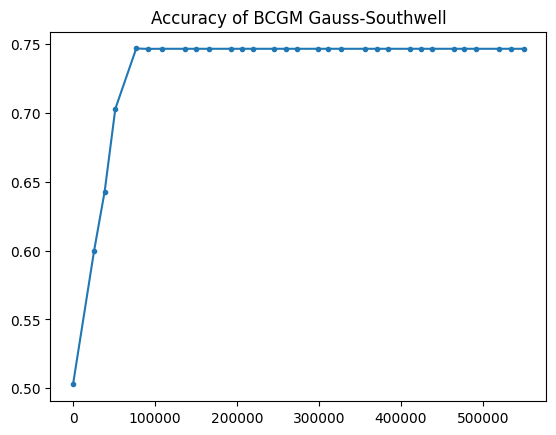

In [753]:
plt.figure(dpi=100)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, acc_bcgd_gs, marker='.')

### Loss

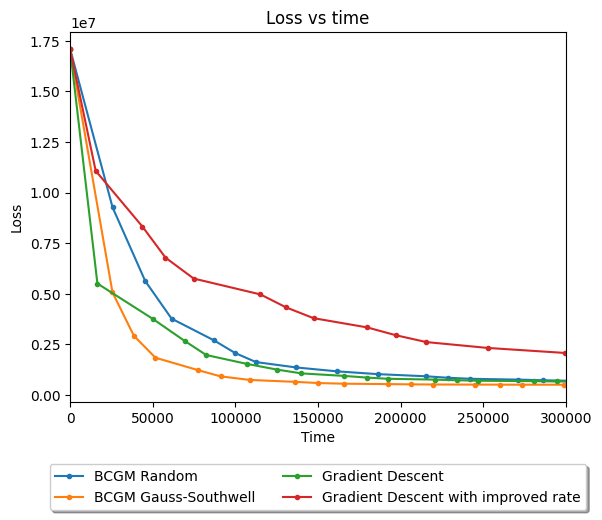

In [763]:
plt.figure(dpi=100)
plt.plot(ticks_bcgd_random , loss_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , loss_bcgm_gs, marker='.')
plt.plot(ticks_gd , loss_gd, marker='.')
plt.plot(ticks_gd_improved , loss_gd_improved, marker='.')


plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,300000)
plt.legend(
    [
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)

## Accurancy

### Only BCGM compared

In [755]:
min_acc = np.min(np.concatenate((acc_bcgd_random, acc_bcgd_gs)))
max_acc = np.max(np.concatenate((acc_bcgd_random, acc_bcgd_gs)))

min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

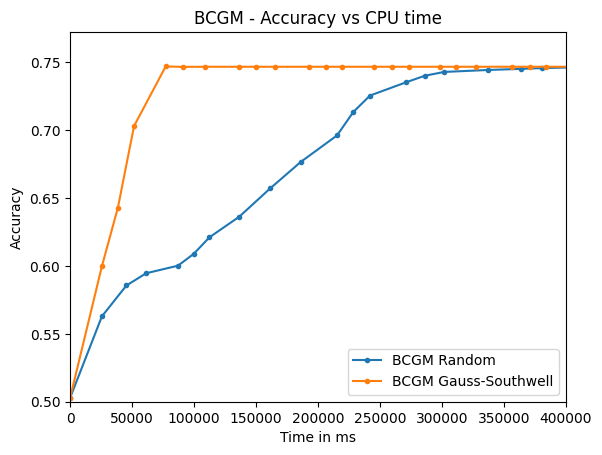

In [766]:
plt.figure(dpi=100)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.ylim(min_y_plot, max_y_plot)
plt.plot(ticks_bcgd_random, acc_bcgd_random, marker='.')
plt.plot(ticks_bcgd_gs, acc_bcgd_gs, marker='.')

plt.title("BCGM - Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.xlim(-10,400000)
plt.legend(
    ['BCGM Random', 'BCGM Gauss-Southwell'],
    loc="lower right"
)

### Only Gradient Descent Compared

In [757]:
min_acc = np.min(np.concatenate((acc_gd, acc_gd_improved)))
max_acc = np.max(np.concatenate((acc_gd, acc_gd_improved)))

min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

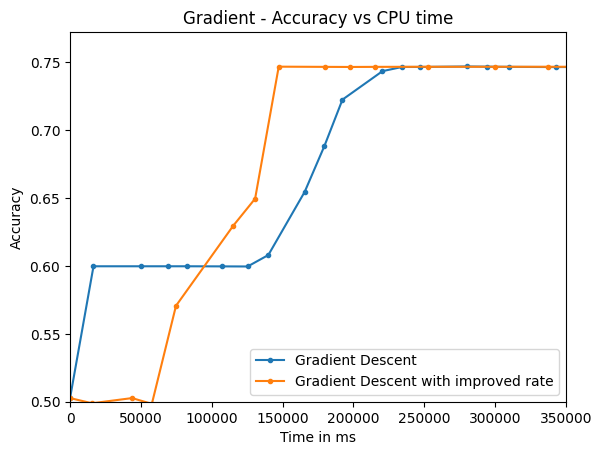

In [767]:
plt.figure(dpi=100)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.ylim(min_y_plot, max_y_plot)
plt.plot(ticks_gd, acc_gd, marker='.')
plt.plot(ticks_gd_improved, acc_gd_improved, marker='.')

plt.title("Gradient - Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.xlim(-10,350000)
plt.legend(
    ['Gradient Descent', 'Gradient Descent with improved rate'],
    loc="lower right"
)